In [80]:
from matplotlib import rcParams
import matplotlib.ticker as ticker
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Georgia']

In [82]:
pwd

'/Users/americanthinker/DataScience/Projects/dental-project/notebooks'

In [86]:

pat = pd.read_csv('../data/interm/patient_cleaned.csv', infer_datetime_format=True)
appt = pd.read_csv('../data/interm/appt_cleaned.csv', infer_datetime_format=True, low_memory=False)
pay = pd.read_csv('../data/interm/pay_cleaned.csv',  low_memory=False)

In [97]:
raw = pd.read_csv('../data/raw/appt.csv')
appt = pd.read_csv('../data/raw/appt.csv', usecols=['PatNum', "AptStatus", 'AptDateTime'])
appt = appt[appt['AptStatus'] != 5]


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (14,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [98]:
appt.AptStatus.value_counts()

2    64842
1      883
3      140
Name: AptStatus, dtype: int64

In [99]:
appt.drop('AptStatus', axis=1, inplace=True)

In [100]:
appt = appt[appt['AptDateTime'] != '0001-01-01 00:00:00'].sort_values('AptDateTime')

#### Drop uneeded patient columns

In [101]:
appt.groupby('PatNum')['AptDateTime'].count().sort_values().tail(6).index.tolist()

[3645, 5686, 3391, 2, 5557, 2661]

In [94]:
appt = appt[~appt['PatNum'].isin([3645, 5686, 3391, 2, 5557, 2661])]

In [103]:
appt['AptDateTime'] = appt['AptDateTime'].str[:10]
appt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65863 entries, 41544 to 15339
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PatNum       65863 non-null  int64 
 1   AptDateTime  65863 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [105]:
appt['AptDateTime'] = pd.to_datetime(appt['AptDateTime'])

In [106]:
pat = pat.iloc[:, :-1]
pat.drop(['Address', 'Address2', 'ImageFolder', 'ChartNumber', 'Premed'], axis=1, inplace=True)

In [108]:
pat['fullname'] = pat['FName'] + ' ' + pat['LName']
pat['fullname'] = pat['fullname'].str.lower()

#### Filled 16 DateFirstVisit bad entries with AptDateTime

In [7]:
bad_entries = pat[pat['DateFirstVisit'] == '0001-01-01'].PatNum.tolist()
fixed_records = appt[appt['PatNum'].isin(bad_entries)][['PatNum', 'AptDateTime']]
fixed_records['AptDateTime'] = pd.to_datetime(fixed_records['AptDateTime']).dt.date
fixed_records = fixed_records.sort_values('PatNum')
inds = pat[pat['PatNum'].isin(fixed_records['PatNum'])].sort_values('PatNum').index

In [8]:
for index, date in zip(inds, fixed_records['AptDateTime']):
    pat.loc[index, 'DateFirstVisit'] = date

In [9]:
#Duplicated patients code
#pat[pat.loc[:, ['Birthdate', 'fullname']].duplicated(keep=False)].sort_values('fullname').head(100)

In [10]:
w.downcast(pat)
w.downcast(appt)

### Build Recency Table for Kmeans

In [110]:
recency = appt.merge(pat)
recency['AptDateTime'] = recency.AptDateTime.dt.date
recency['AptDateTime'] = pd.to_datetime(recency['AptDateTime'])

In [12]:
pat.to_csv('data/patient_int.csv', index=False)

In [111]:
from datetime import datetime
now = pd.to_datetime(datetime.now())
now = pd.to_datetime(now.date())
maxdates = recency.groupby('PatNum')['AptDateTime'].max()
maxdates = maxdates.to_frame().reset_index()
maxdates['recency'] = (now - maxdates['AptDateTime']).dt.days

In [14]:
maxdates.to_csv('data/recency.csv', index=False)

### Recency Distribution

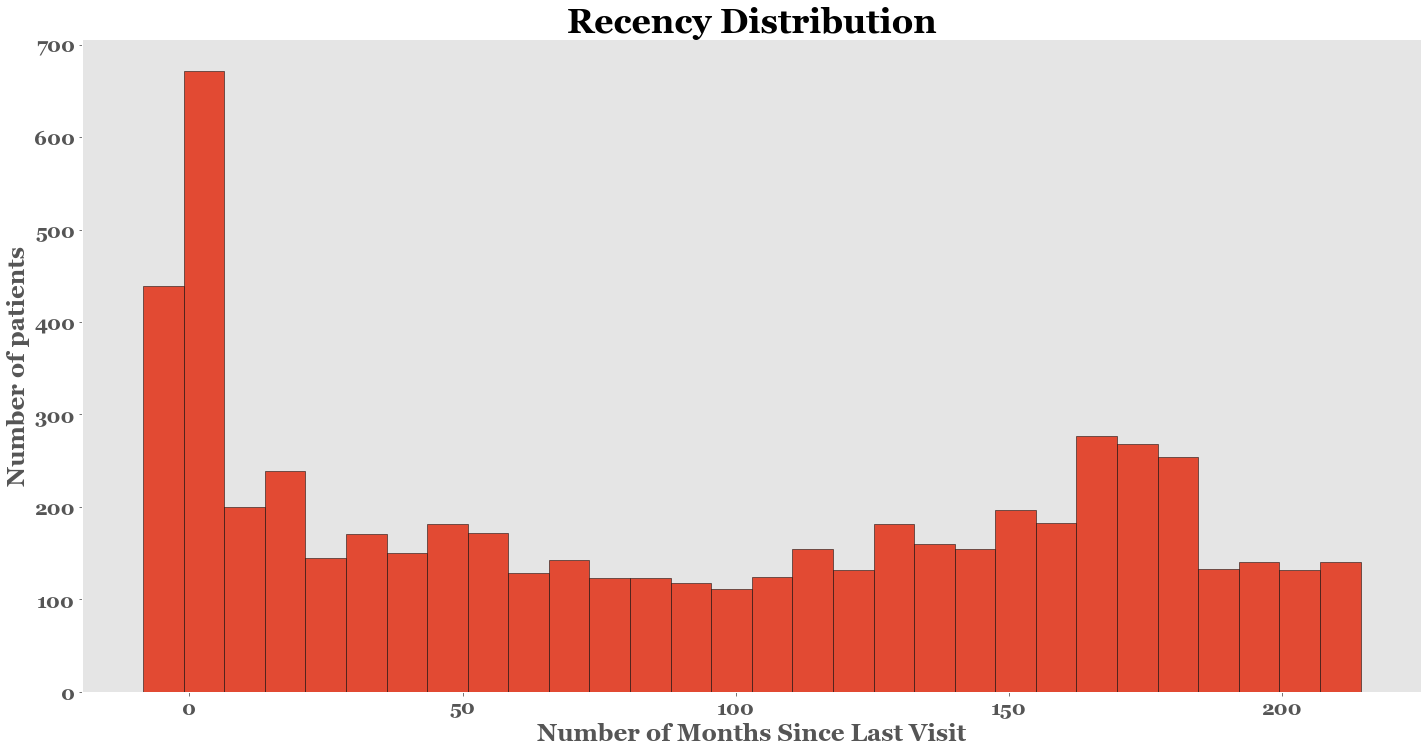

In [112]:
fig = plt.figure(figsize=(24, 12))
plt.style.use('ggplot')
plot = (maxdates['recency']/30).hist(bins=30, edgecolor='black')
title = plt.title('Recency Distribution', fontweight='bold', fontsize=34)
xticks = plt.xticks(fontweight='bold', fontsize=20)
yticks = plt.yticks(fontweight='bold', fontsize=20)
xlabel = plt.xlabel('Number of Months Since Last Visit', fontweight='bold', fontsize = 24)
ylabel = plt.ylabel('Number of patients',  fontweight='bold', fontsize = 24)
plt.grid(False)

In [18]:
pay_table = pay.groupby('PatNum')['PayAmt'].agg({'sum', 'mean'}).reset_index()
pay_table.rename(columns={'sum':'total_value', 'mean':'mean_value'}, inplace=True)

In [23]:
pay_table.sort_values(['total_value', 'mean_value'], ascending=False).head()

,PatNum,total_value,mean_value
2998,5361,27413.00,480.929825
785,1516,25470.00,369.130435
28,38,21465.63,212.530990
576,1134,21445.84,174.356423
1749,3168,21439.90,397.035185


In [31]:
test = maxdates.merge(pay_table)

In [32]:
test2 = test.merge(pay_table).drop('mean_value', axis=1)

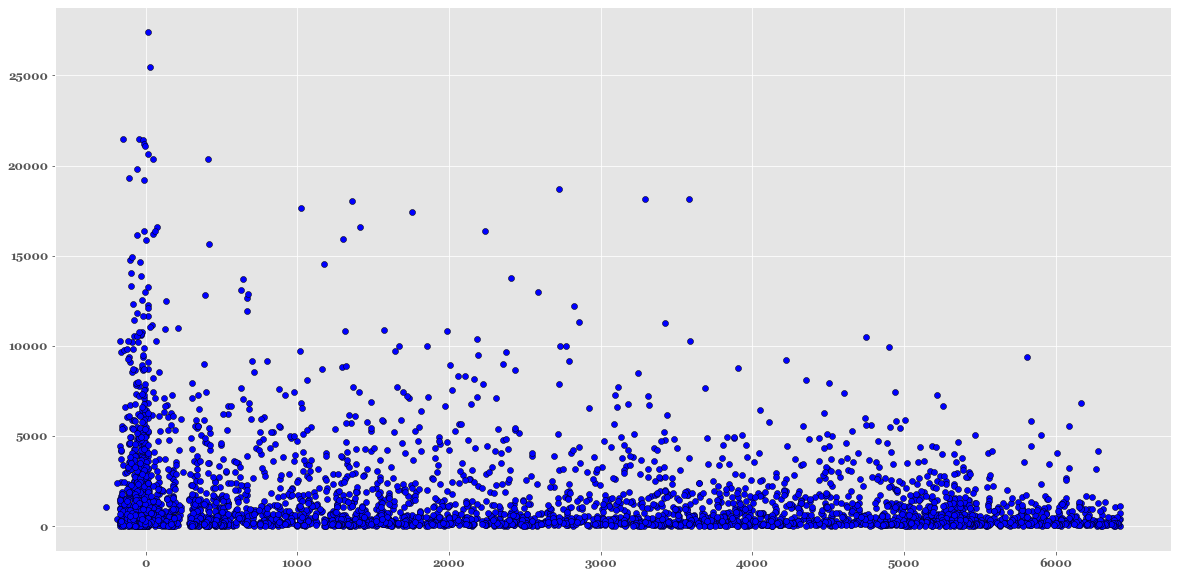

In [33]:
X = test2.recency
y = test2.total_value
plt.scatter(X, y, edgecolor='black', c='blue')

In [34]:
len(set(test.PatNum).intersection(set(pay_table.PatNum)))

3896

In [36]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=4)
kmeans.fit(test[['recency']])
test['RecencyCluster'] = kmeans.predict(test[['recency']])

KMeans(n_clusters=4)

In [37]:
test.groupby("RecencyCluster")['recency'].describe().sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
2,1426.0,174.947405,303.530631,-261.0,-43.0,14.0,361.75,977.0
0,837.0,1768.808841,486.344178,978.0,1352.0,1707.0,2164.00,2715.0
3,794.0,3651.056675,511.667228,2716.0,3235.0,3667.5,4077.50,4529.0
1,839.0,5416.132300,499.533188,4533.0,5031.0,5363.0,5806.50,6426.0


In [38]:
target_group = test.query('RecencyCluster == 3')

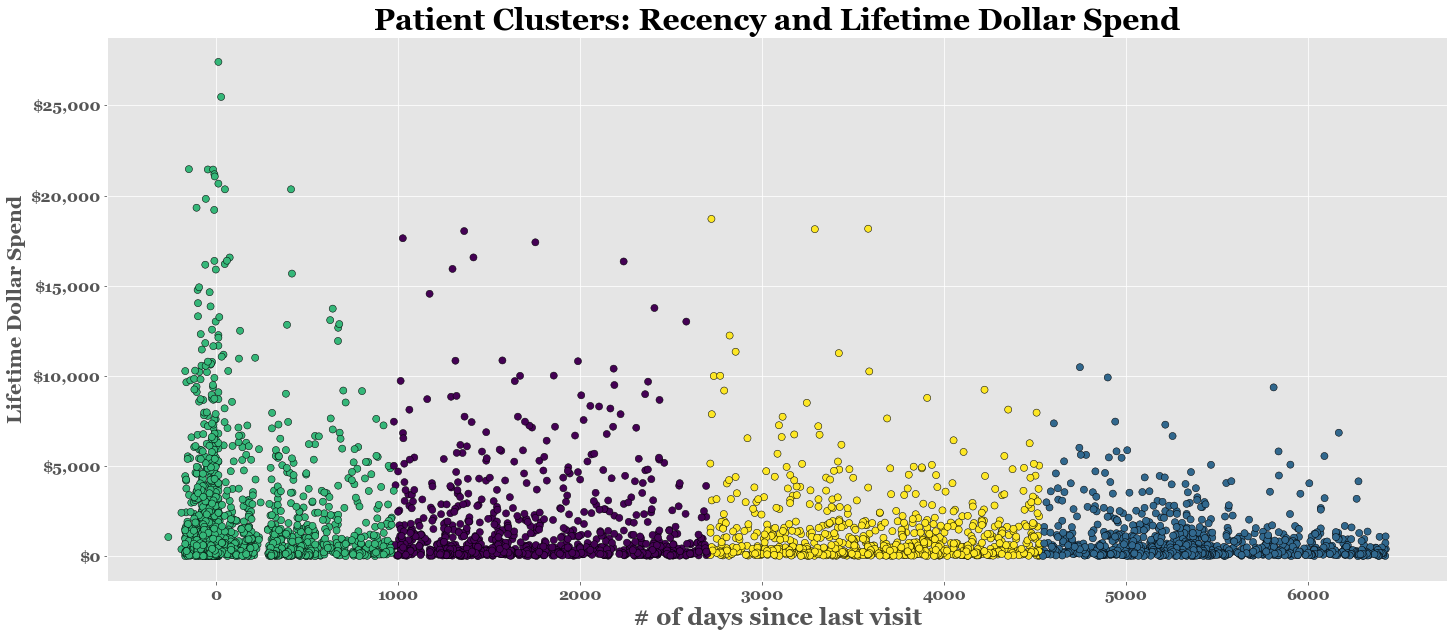

In [50]:
X = test.recency
y = test.total_value
colors = test.RecencyCluster
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
plot = plt.scatter(X, y, c=colors, s=50, cmap='viridis', edgecolor='black')
fmt = '${x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
xticks = plt.xticks(fontweight='bold', fontsize=16)
yticks = plt.yticks(fontweight='bold', fontsize=16)
xlabel = plt.xlabel('# of days since last visit', fontweight='bold', fontsize = 24)
ylabel = plt.ylabel('Lifetime Dollar Spend',  fontweight='bold', fontsize = 20)
title = plt.title('Patient Clusters: Recency and Lifetime Dollar Spend', fontweight='bold', fontsize=30)

<ipython-input-45-a1194ac67683>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  krecency["clusters"] = kmeans.labels_
<ipython-input-45-a1194ac67683>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  krecency["clusters"] = kmeans.labels_
<ipython-input-45-a1194ac67683>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

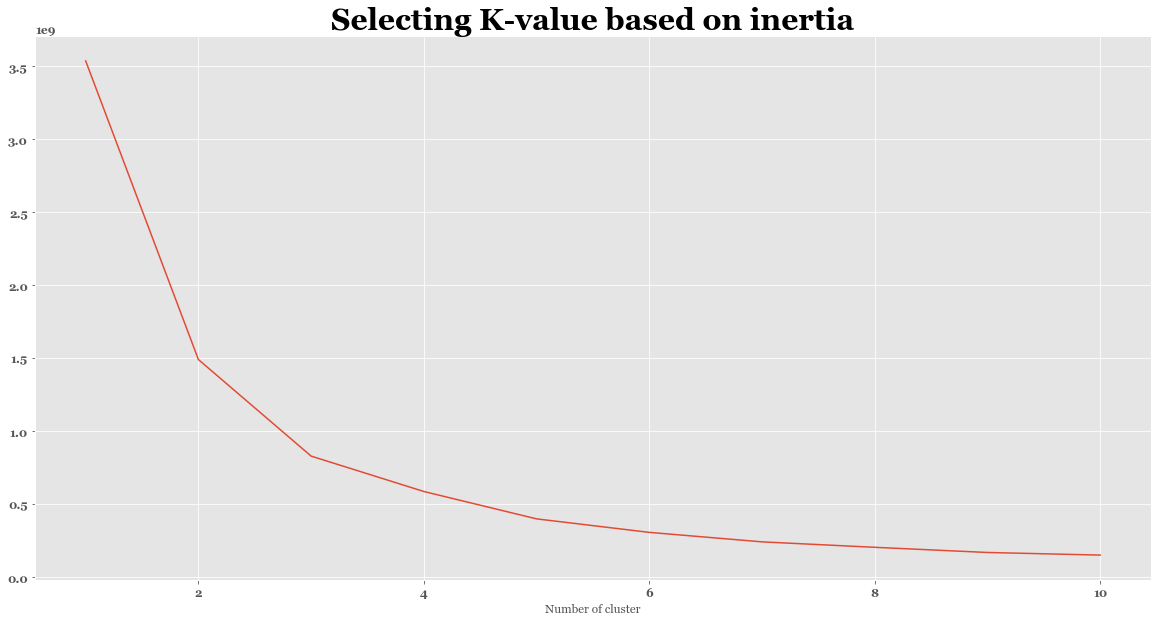

In [45]:
sse={}
krecency = target_group[['recency', 'total_value']]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(krecency)
    krecency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
fig = plt.figure(figsize=(20,10))
plot = plt.plot(list(sse.keys()), list(sse.values()))
xlabel = plt.xlabel("Number of cluster")
title = plt.title('Selecting K-value based on inertia', fontsize=30, fontweight='bold')

In [98]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(target_group[['total_value']])
target_group['RecencyCluster'] = kmeans.predict(target_group[['total_value']])

KMeans(n_clusters=3)

/Users/americanthinker/anaconda/envs/snakes/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [99]:
target_group

,recency,total_value,mean_value,RecencyCluster
1,-97,10216.24,138.057297,1
2,-83,4301.22,113.190000,2
3,-154,21465.63,210.447353,1
4,-103,4914.90,65.532000,2
5,-34,4829.30,137.980000,2
...,...,...,...,...
1879,-152,43.00,21.500000,0
1880,-12,300.00,150.000000,0
1881,-33,593.50,296.750000,0
1882,-167,280.00,140.000000,0


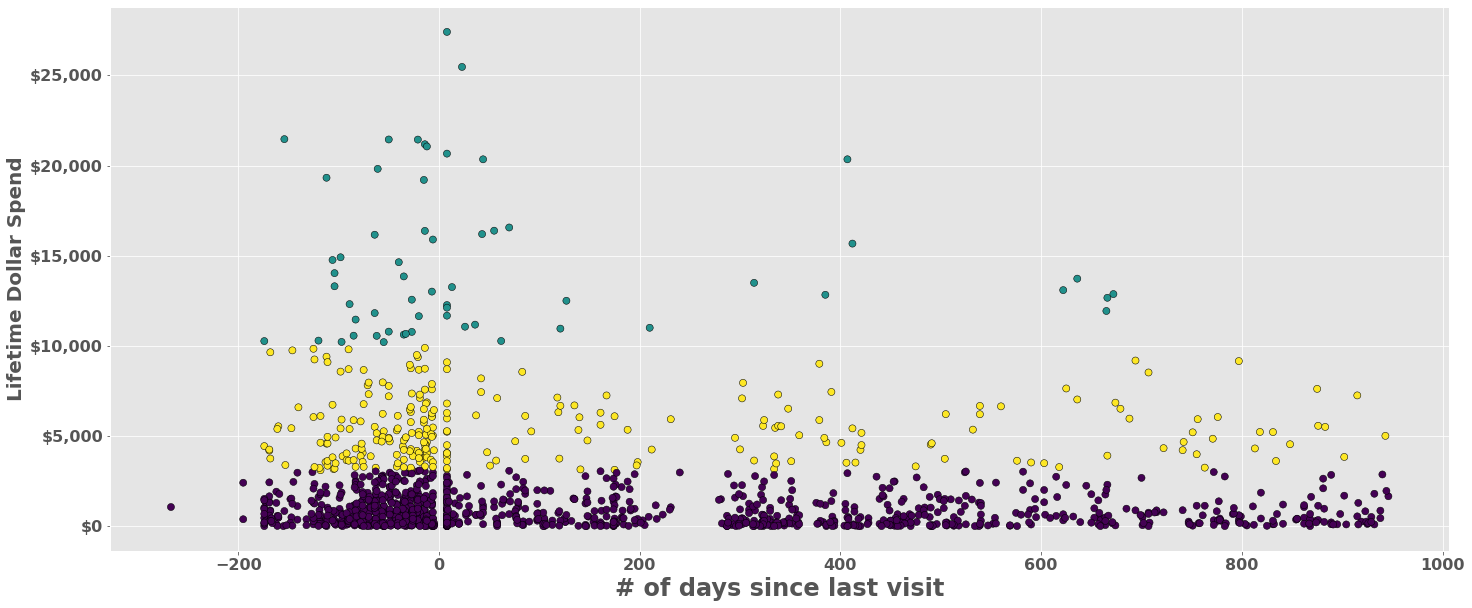

In [137]:
X = target_group.recency
y = target_group.total_value
colors = target_group.RecencyCluster
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
plot = plt.scatter(X, y, c=colors, s=50, cmap='viridis', edgecolor='black')
fmt = '${x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
xticks = plt.xticks(fontweight='bold', fontsize=16)
yticks = plt.yticks(fontweight='bold', fontsize=16)
xlabel = plt.xlabel('# of days since last visit', fontweight='bold', fontsize = 24)
ylabel = plt.ylabel('Lifetime Dollar Spend',  fontweight='bold', fontsize = 20)

In [142]:
order_cluster('RecencyCluster', 'recency', target_group, False).groupby("RecencyCluster")['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1124.0,178.668149,298.833510,-267.0,-47.0,14.5,386.0,946.0
1,263.0,133.406844,289.379037,-174.0,-56.0,-12.0,318.5,943.0
2,59.0,61.203390,218.548723,-174.0,-61.5,-14.0,49.5,672.0


### Calculating Overall Churn Rate

In [53]:
appt['AptDate'] = pd.to_datetime(appt['AptDate'])

In [55]:
now = pd.to_datetime('now')

In [64]:
max_date = appt.groupby('PatNum')['AptDate'].max()

In [65]:
days = (now-max_date).dt.days

In [70]:
(days >= 540).sum()/len(days)

0.7328005559416261

In [61]:
recency = pd.read_csv('data/recency.csv')

In [75]:
recency.sort_values('AptDateTime')

,PatNum,AptDateTime,recency
501,1922,2003-06-02,6427
378,1712,2003-06-03,6426
469,1870,2003-06-04,6425
562,2007,2003-06-04,6425
442,1824,2003-06-05,6424
...,...,...,...
5737,8527,2021-06-24,-170
4484,6938,2021-07-13,-189
5549,8273,2021-07-13,-189
5550,8274,2021-07-13,-189


In [103]:
pat = pd.read_csv('data/interm/patients_2016.csv')

In [104]:
pat['DateFirstVisit'] = pd.to_datetime(pat['DateFirstVisit'])

In [105]:
now = pd.to_datetime('now')
days = (now - pat['DateFirstVisit']).dt.days
days.name = 'days_since_1st'

In [106]:
pat = pd.concat([pat, days], axis=1)

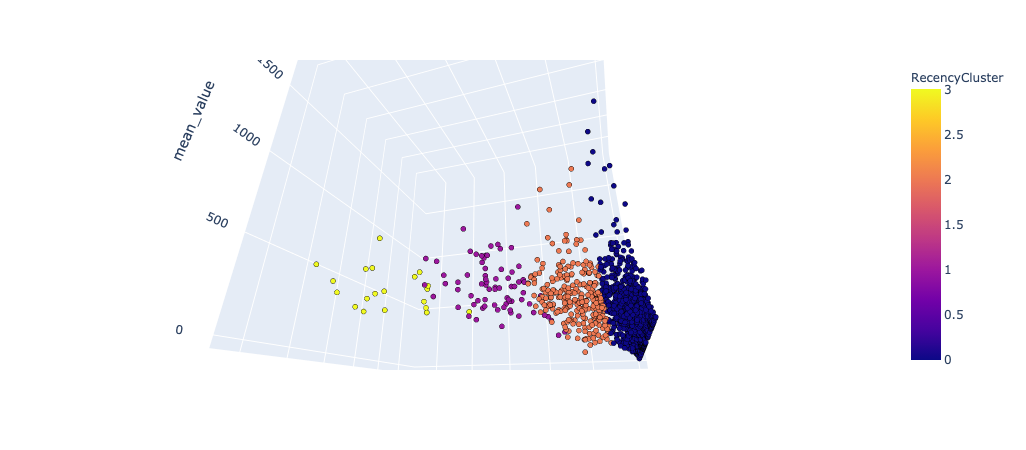

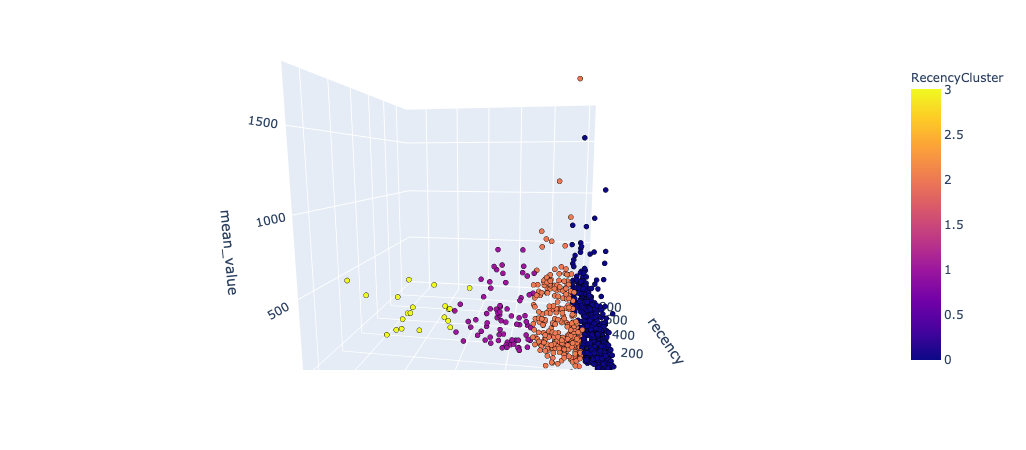

In [87]:
import plotly.express as px
fig = px.scatter_3d(target_group, x='recency', y='total_value', z='mean_value',
              color='RecencyCluster')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=2,
                                        color='black')),
                  selector=dict(mode='markers'))
fig.show()

In [113]:
pt = pd.read_csv('/Users/americanthinker/Downloads/appt_cleaned.csv', infer_datetime_format=True)

/Users/americanthinker/anaconda/envs/snakes/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



In [114]:
pt.head()

,AptNum,PatNum,AptStatus,Confirmed,Op,Note,ProvNum,AptDateTime,InsPlan1,InsPlan2,ProcsColored
0,51336,5676,2,21,1,pro/exam\r\n,6,2016-07-14 13:00:00,1143,0,NaN
1,51337,5676,2,21,2,loose filling UL #13\r\n--------------- Mon - ...,1,2016-07-19 10:00:00,1143,0,NaN
2,51338,1563,2,21,1,"pro/exam\r\n--------------- Mon - Jan 9, 2017 ...",2,2017-01-17 14:00:00,572,0,NaN
3,51339,5326,2,361,1,"pro/exam only\r\n--------------- Mon - Jan 9, ...",2,2017-01-18 14:00:00,2268,0,NaN
4,51340,5167,2,21,1,"Pro\r\n--------------- Mon - Jan 9, 2017 -----...",6,2017-05-04 15:00:00,1389,0,NaN


In [116]:
notes = pt.Note

In [129]:
clean_notes = notes.str.strip().str.replace('\n', '').str.replace('\r', '').str.lower()

In [136]:
clean_notes[clean_notes.str.contains('prophy')].str.replace(',','').str.replace('/', ' ').value_counts().head(50)

prophy                           1222
exam 4bw prophy                   248
prophyad                          239
exam prophy                       125
prophy fmp                         96
prophy exam                        81
4bw prophy                         78
exam 4bw pa1st pa prophy           63
prophy flo                         51
exam fmx prophy                    38
prophy flv                         25
exam prophy fmp                    25
exam 4bw pa prophy pa              19
prophych                           19
4bw pa1st pa prophy                17
fmx prophy                         17
exam 4bw prophy flo                16
exam 4bw pa1st prophy              14
exam 4bw pa prophy                 12
4bw prophy flo                     10
prophy adult                       10
fmx prophy np exam                  9
prophy flo fmp                      9
prophyad exam 4 bws                 8
exam prophy flo                     7
prophy bwx exam                     7
prophyad exa